# Computing velocities from positions


If you run this notebook on your own computer (recommended), need:
* julia (https://julialang.org/downloads/#official_binaries_for_manual_download)
* packages `PythonPlot` and `DelimitedFiles`, and `DSP`, which you can install with the following julia commands:

```julia
using Pkg
Pkg.add(["PythonPlot","DelimitedFiles","DSP"])
```

But the packages need to be installed before the lecture.
The steps above are not necessary if you run on the server, but you need download your files after each lesson (as they are deleted). 

Exercice:

* Compute the drifter velocities from the provided file (drifter 1).
* Smooth the data with a Buttworth filter (with a cut-off frequency corresponding to a period of 30 minutes) from the DSP package
* Plot the trajectory and the currents with the coastline and bathymetrie (isodepth 25 m, 50 m, 75 m, 100 m)
  
Data files:
* Drifter positions: https://dox.ulg.ac.be/index.php/s/A3KkDQYmdNLlabx/download 
* Bathymetry: https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download




This is the metadata for the deployement from previous students:

```
Heures de relargage des drifters le 06 mai :
1 10:29 – 15:04
2 10:33 – 15:13
3  10:31 – 15:10
4 10:37 – 15:18
5 10:30 – 15:07
6 10:27 – 14:56
7 10:35 – 15:15
8 10:28 – 14-59
9 10:39 – 15:21
10 10:32 – 15:12

Timing drifters le 08 mai: 
1: 9h12-14h31 
2: 9h14-14h37 
3: 9h07-14h12 
4: 9:11-14h26 
5: 9h10-14h20 
6: 9h13-14h32 
7: 9h14-14h34 
8: 9h08-14h12 
9: 9h06-14h18 
10: 9h09-14h24
```

The year is 2024 and the time are in local time (GMT-2).

In [145]:
using PythonPlot
using Dates
using DelimitedFiles
using Statistics
using DSP # DSP version 0.7.9
using Downloads: download

This download an example file:

In [153]:
filename = "Drifter01_08-05-2024.txt"

if !isfile(filename)
    download("https://dox.ulg.ac.be/index.php/s/A3KkDQYmdNLlabx/download",filename)
end

The text file is a comma separated value file (CSV) where the columns are longitude, latitude, time

In [154]:
D = readdlm(filename,',');
time = DateTime.(D[:,1]);
lon = D[:,2]
lat = D[:,3];

Make a simple plot with the axis longitude and latitude

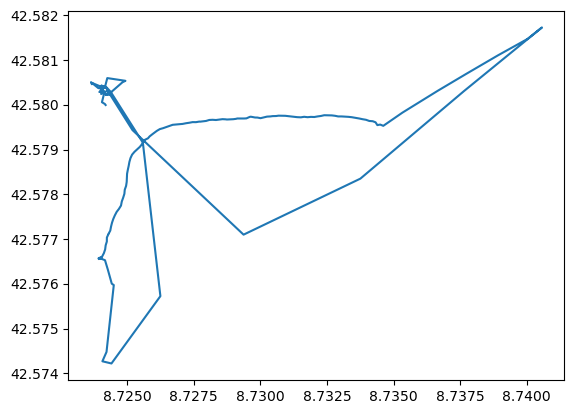

In [155]:
plot(lon,lat);

Plot the data during deployement:

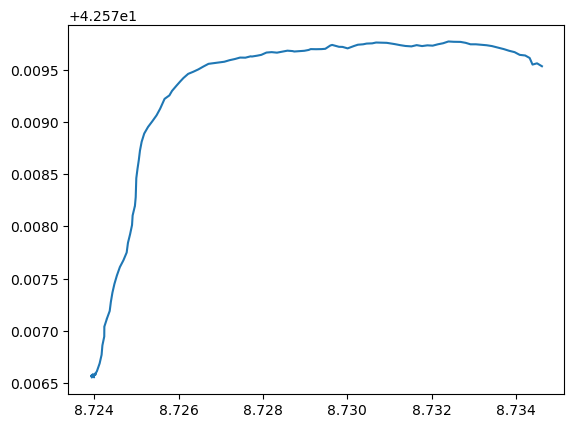

In [6]:
t0 = DateTime(2024,5,8,9,12) - Dates.Hour(2)
t1 = DateTime(2024,5,8,14,31)  - Dates.Hour(2)

sel = t0 .<= time .<= t1
plot(lon[sel],lat[sel]);

In [7]:
lon = lon[sel];
lat = lat[sel];
time = time[sel];


Sklip also the part where the drifter does not move and the end (because it is was stuck at the coast)

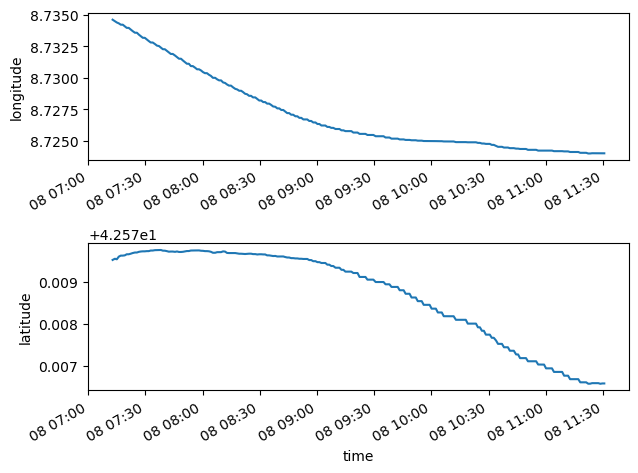

In [149]:
t0 = DateTime(2024,5,8,9,12) - Dates.Hour(2)
t1 = DateTime(2024,5,8,11,31)

sel = t0 .<= time .<= t1

lon = lon[sel];
lat = lat[sel];
time = time[sel];


subplot(2,1,1); 
plot(time,lon)
ylabel("longitude")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

subplot(2,1,2); 
plot(time,lat)
ylabel("latitude")
xlabel("time")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");
tight_layout();

In [9]:
zoom = 13
lon_deg = lon[1]
lat_deg = lat[1]

# compute from longitude and latitude in degrees and the zoom level the 
# corresping tile indices.
function deg2num(lon_deg,lat_deg,zoom)
   lat_rad = pi/180 * lat_deg
   n = 2 ^ zoom
   xtile = floor(Int,n * ((lon_deg + 180) / 360))
   ytile = floor(Int,n * (1 - (log(tan(lat_rad) + sec(lat_rad)) / π)) / 2)
   return (xtile,ytile) 
end

xtile,ytile = deg2num(lon_deg,lat_deg,zoom)

(4294, 3023)

Compute the lonitude and latitude position from tile indices

In [10]:
function num2deg(xtile, ytile, zoom)
  n = 2.0^zoom
  lon_deg = xtile / n * 360 - 180
  lat_rad = atan(sinh(pi * (1 - 2 * ytile / n)))
  lat_deg = 180/pi * lat_rad
  return (lon_deg, lat_deg)
end

num2deg (generic function with 1 method)

longitude/latitude of the North-West corner 

In [11]:
lon0,lat1 = num2deg(xtile, ytile, zoom)

(8.701171875, 42.5854442573849)

longitude/latitude of the South-East corner

In [12]:
lon1,lat0 = num2deg(xtile+1, ytile+1, zoom)

(8.7451171875, 42.553080288955805)

Initial position of the GPS track 

In [13]:
lon[1],lat[1]

(8.734615, 42.579533)

URL of the image

In [14]:
URL = "https://tile.openstreetmap.org/$zoom/$xtile/$ytile.png"

"https://tile.openstreetmap.org/13/4294/3023.png"

Download image from Open Steet Map

In [15]:
img = imread(download(URL));

Plot the GPS track with the Open Steet Map basemap

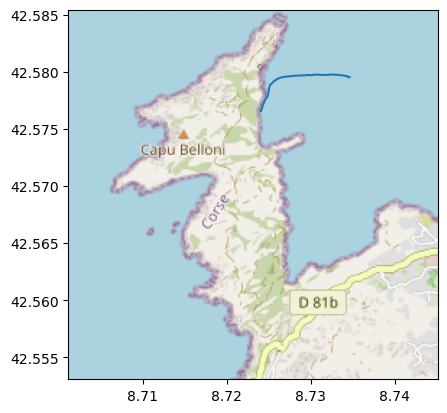

In [16]:
imshow(img,extent = (lon0,lon1,lat0,lat1), origin = "upper");
plot(lon,lat,"-")
gca().set_aspect(1/cosd(lat1));

The convert the position to in a velocity we need to Earth Radius

In [17]:
# Mean radius (http://en.wikipedia.org/wiki/Earth_radius)
R = 6371.009e3;

1 degree in the North-South direction corresponds approximately 111 km.

In [18]:
2*pi*R/360

111195.08372419141

In [19]:
time[1]

2024-05-08T07:12:53

In [20]:
time[2]

2024-05-08T07:14:04

`Dates.value` returns a duration in milliseconds

In [21]:
i=2
Dates.value(time[i+1]-time[i-1])

133000

compute the u (East-West) and v (North-South) velocity component

In [44]:
u = fill(NaN,size(lon))
v = fill(NaN,size(lat))

for i = 2:length(lon)-1
    # convert milliseconds to seconds
    DeltaT = Dates.value(time[i+1]-time[i-1]) / 1000
    v[i] = π*R/180 * (lat[i+1] - lat[i-1]) / DeltaT
    # cosd computes the cosinus of an angle in degree
    u[i] = π*R/180 * (lon[i+1] - lon[i-1]) / DeltaT   * cosd(lat[i])
end



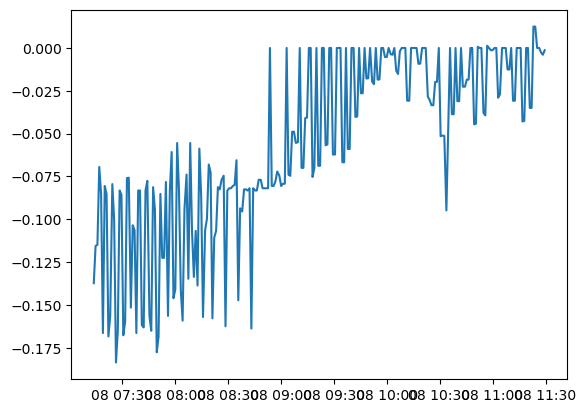

Python: [<matplotlib.lines.Line2D object at 0x7f93832a4c10>]

In [23]:
plot(time,u)

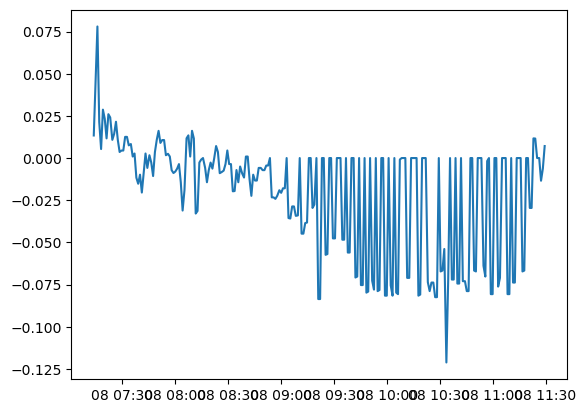

Python: [<matplotlib.lines.Line2D object at 0x7f9383332150>]

In [24]:
plot(time,v)

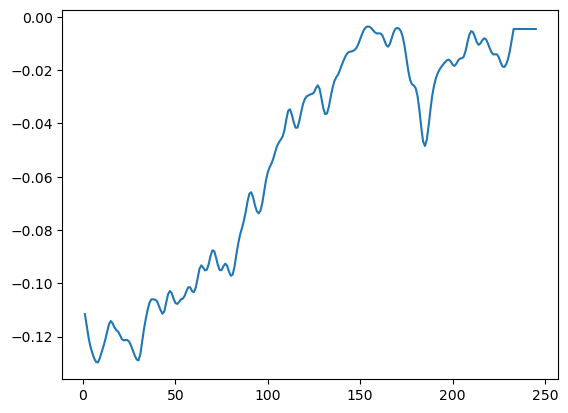

Python: [<matplotlib.lines.Line2D object at 0x7f938b4f2390>]

In [25]:
using PhysOcean: gaussfilter

plot(gaussfilter(u,12))

In [49]:
time[1:4]

4-element Vector{DateTime}:
 2024-05-08T07:12:53
 2024-05-08T07:14:04
 2024-05-08T07:15:06
 2024-05-08T07:16:08

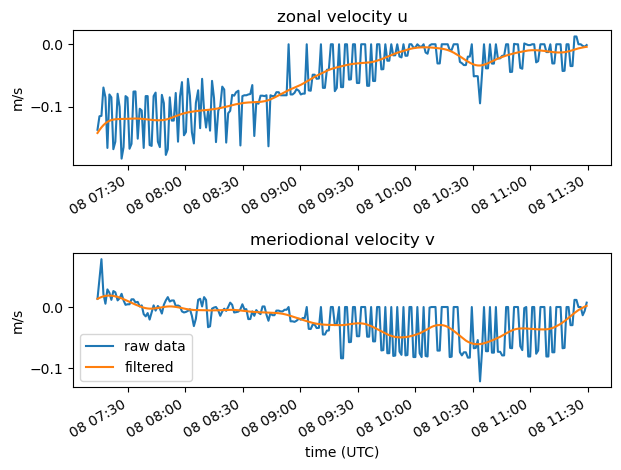

Python: None

In [131]:
# Filter parameters
fs = 1/60 # sampling frequency (Hz)
# Cutoff frequency (Hz), 30 minutes
fc = 1/(30*60)

# Order of the Butterworth filter
order = 2

responsetype = Lowpass(fc, fs=fs)
designmethod = Butterworth(order)
bfilter = digitalfilter(responsetype, designmethod)

uf = filtfilt(bfilter, u[2:end-1])
vf = filtfilt(bfilter, v[2:end-1]);
lonf = lon[2:end-1]
latf = lat[2:end-1]
timef = time[2:end-1]

subplot(2,1,1);
plot(time,u)
plot(timef,uf)
title("zonal velocity u")
ylabel("m/s")
PythonPlot.setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

subplot(2,1,2);
plot(time,v,label="raw data")
plot(timef,vf,label="filtered")
xlabel("time (UTC)")
ylabel("m/s")
title("meriodional velocity v")
setp(gca().get_xticklabels(), rotation=30, horizontalalignment="right");

legend()
tight_layout()


In [62]:
speedf = sqrt.(uf.^2 + vf.^2);

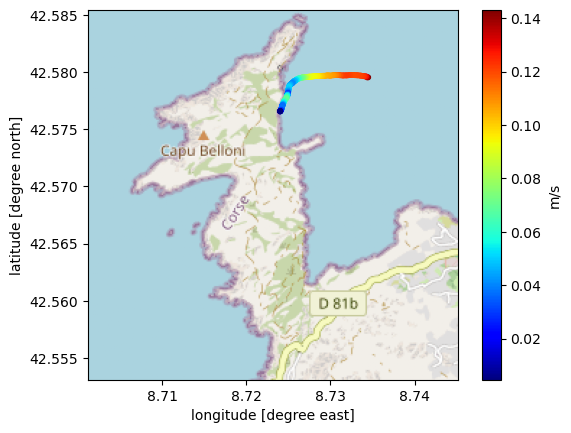

In [115]:
imshow(img,extent = (lon0,lon1,lat0,lat1), origin = "upper");
scatter(lonf,latf,10,speedf,cmap="jet"); colorbar(label="m/s")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
gca().set_aspect(1/cosd(lat1));

Note it might be necessary to download multiple images tiles from Open Street Map. The zoom level (variable `zoom`) might need to be adjusted for your track.
Consider to use the bathymetry for example when plotting your drifter trajectory (using Open Street Map) .

## Bathymetry

Download the bathymetry as a NetCDF file:

In [32]:
bathname = "nwcorsica_bathymetry.nc";

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/9ZwWDbsTgCwgS90/download",bathname)
end

Install NCDatasets with if you using julia on your own computer (`NCDatasets` is already installed on the server):

```julia
using Pkg
Pkg.add("NCDatasets")
```

In [33]:
using NCDatasets
ds = NCDataset(bathname);

Load a subset of the NetCDF file

In [67]:
dss = NCDatasets.@select(ds, 8.7 <= lon <= 8.75 && 42.554 <= lat <= 42.6039)

Dataset: nwcorsica_bathymetry.nc
Group: /

Dimensions
   lat = 100
   lon = 100

Variables
  lat   (100)
    Datatype:    Float64
    Dimensions:  lat
    Attributes:
     long_name            = Latitude
     standard_name        = latitude
     units                = degrees_north

  lon   (100)
    Datatype:    Float64
    Dimensions:  lon
    Attributes:
     long_name            = Longitude
     standard_name        = longitude
     modulo               = 360.0
     units                = degrees_east

  bat   (100 × 100)
    Datatype:    Union{Missing, Float32}
    Dimensions:  lon × lat
    Attributes:
     long_name            = elevation above sea level
     standard_name        = height
     units                = meters
     _FillValue           = 1.0
     missing_value        = 1.0



Load the bathymetry and the corresponding longitude and latitude

In [68]:
bat_lon = dss["lon"][:];
bat_lat = dss["lat"][:];
bat = nomissing(dss["bat"][:,:],NaN);

Plot the bathymetry for the Bay of Calvi

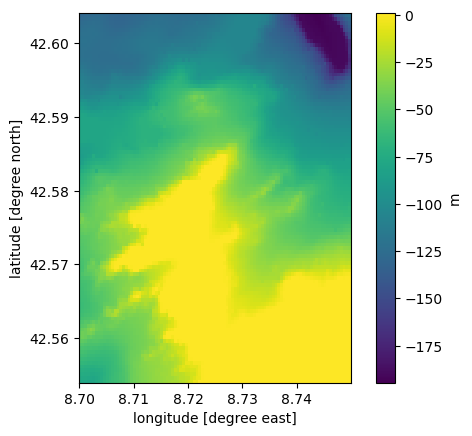

In [113]:
pcolor(bat_lon,bat_lat,bat'); colorbar(orientation="vertical",label="m")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
gca().set_aspect(1/cosd(mean(bat_lat)));


Put land values to an positive value so that the coastline corresponds to the contour line of zero.

In [85]:
bat[isnan.(bat)] .= 1 ;

Plot the result with the bathymetry

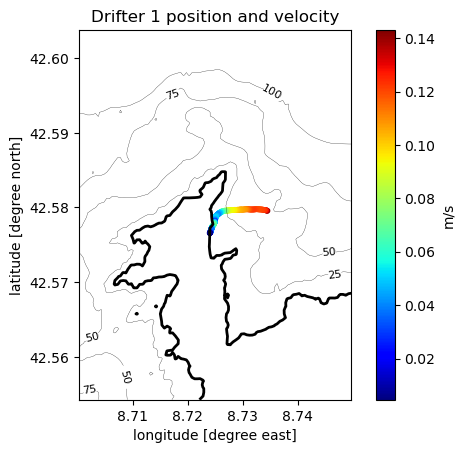

In [111]:
contour(bat_lon,bat_lat,-bat',levels = [0],colors="k",linewidths=2); 
CS = contour(bat_lon,bat_lat,-bat',levels = [25, 50, 75, 100],colors="k",linewidths=0.2); 
gca().clabel(CS, CS.levels, inline=true, fontsize=8)

scatter(lonf,latf,10,speedf,cmap="jet"); colorbar(label="m/s")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
title("Drifter 1 position and velocity")
gca().set_aspect(1/cosd(mean(bat_lat)));

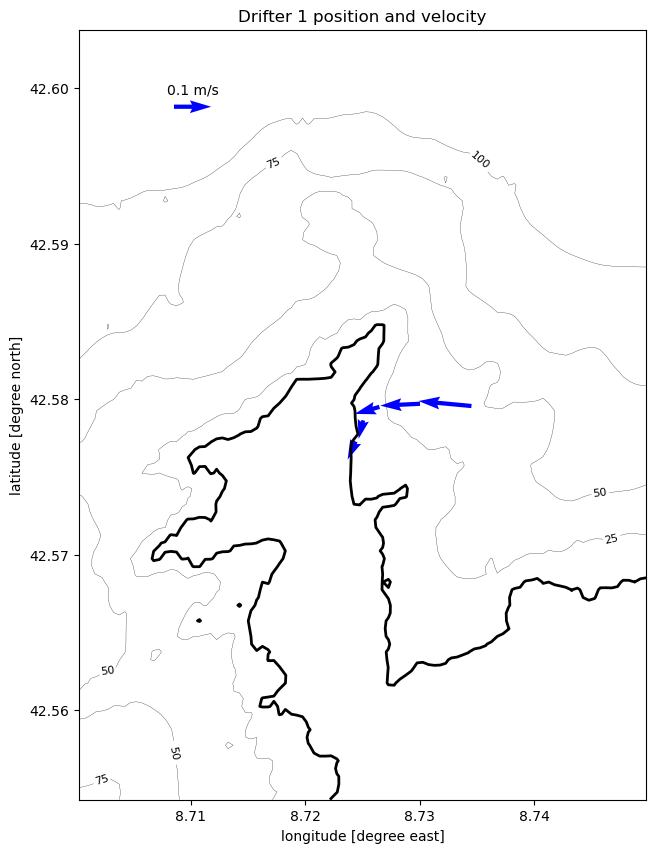

In [144]:
figure(figsize=(10,10))
contour(bat_lon,bat_lat,-bat',levels = [0],colors="k",linewidths=2); 
CS = contour(bat_lon,bat_lat,-bat',levels = [25, 50, 75, 100],colors="k",linewidths=0.2); 
gca().clabel(CS, CS.levels, inline=true, fontsize=8)

s = 1:50:length(lonf)
q = quiver(lonf[s],latf[s],uf[s],vf[s],color="b");
quiverkey(q,0.2,0.9,0.1,label = "0.1 m/s")
xlabel("longitude [degree east]")
ylabel("latitude [degree north]")
title("Drifter 1 position and velocity")
gca().set_aspect(1/cosd(mean(bat_lat)));